In [2]:
from Bio.PDB import *

from scipy.spatial.transform import Rotation as R

from utils.carb_utils import *

import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix as dm
#-alternate_3_letter_codes pdb_sugar
#-out:level 100

#-beta
#-auto_detect_glycan_connections
#-alternate_3_letter_codes pdb_sugar



import os
import numpy as np
import pandas as pd
import copy

BOND_CUT = 1.75
INTERACT = 4.5

input_dir = "./"
os.chdir(input_dir)

In [ ]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.teaching import *

from pyrosetta.rosetta.protocols.carbohydrates import *
from pyrosetta.rosetta.core.select.residue_selector import *
from pyrosetta.rosetta.core.simple_metrics.metrics import *
from pyrosetta.rosetta.core.simple_metrics.composite_metrics import *
from pyrosetta.rosetta.core.simple_metrics.per_residue_metrics import *

options = """
-ignore_unrecognized_res
-include_sugars
-auto_detect_glycan_connections
-maintain_links 
-alternate_3_letter_codes pdb_sugar
-write_glycan_pdb_codes
-ignore_zero_occupancy false 
-load_PDB_components false
-no_fconfig

-out:level 100
"""

init(" ".join(options.split('\n')))

In [ ]:
sc = get_score_function()
fr = pyrosetta.rosetta.protocols.relax.FastRelax()
fr.set_scorefxn(sc)
fr.max_iter(100)

In [ ]:
ls = os.listdir

In [2]:
#Get list of proteins
pdb = [];

df = pd.read_csv('./carbbinders_pdblist.txt',header=None).values

print(len(df),df)

6559 [['3old']
 ['3ole']
 ['1pig']
 ...
 ['5DFM']
 ['4A34']
 ['5HQJ']]


In [3]:
ls = os.listdir('./pdbs')
print(len(ls))

6251


In [3]:
gly = '''N-acetyl-beta-D-glucosamine (NAG), beta-D-glucopyranose (BGC),
alpha-D-glucopyranose (GLC), alpha-D-mannopyranose (MAN),
beta-D-galactopyranose (GAL), alpha-L-fucopyranose (FUC),
beta-D-mannopyranose (BMA), N-acetyl-alpha-D-mannosamine (BM3), nonyl
beta-D-glucopyranoside (BNG), beta-D-xylopyranose (XYP),
uridine-diphosphate-n-acetylglucosamine (UD1), N-acetyl-alpha-D-galactosamine
(A2G), undecyl-maltoside (UMQ), N-acetyl-beta-D-galactosamine (NGA),
galactose-uridine-5-diphosphate (GDU), 6-O-phosphono-beta-D-glucopyranose
(BG6), N-acetyl-beta-neuraminic acid (SLB), N-acetyl-alpha-neuraminic acid (SIA), (NEU),
fructose -6-phosphate (F6R), alpha-D-galactopyranose (X6X),
1,6-di-O-phosphono-D-fructose (P6F), 2-amino-2-deoxy-alpha-D-glucopyranose
(PA1), 2-amino-2-deoxy-beta-D-galactopyranose (1GN), alpha-L-rhamnopyranose
(RAM), alpha-D-Abequopyranose (ABE), alpha-D-glucopyranuronic acid (GCU),
2-acetamido-2-deoxy-4-O-sulfo-beta-D-galactopyranose (ASG),
alpha-L-gulopyranuronic acid (LGU), alpha-L-arabinofuranose (AHR),
beta-D-galactofuranuronic acid (GTK), beta-D-glucopyranuronic acid (BDP),
beta-L-fructofuranose (LFR) and cyclodextrins'''

carb = [];
gly = gly.split('(')
#print(gly)
for jj in range(len(gly)):
    if ')' in gly[jj]:
        carb.append(gly[jj].split(')')[0])
print(carb)

['NAG', 'BGC', 'GLC', 'MAN', 'GAL', 'FUC', 'BMA', 'BM3', 'BNG', 'XYP', 'UD1', 'A2G', 'UMQ', 'NGA', 'GDU', 'BG6', 'SLB', 'SIA', 'NEU', 'F6R', 'X6X', 'P6F', 'PA1', '1GN', 'RAM', 'ABE', 'GCU', 'ASG', 'LGU', 'AHR', 'GTK', 'BDP', 'LFR']


In [4]:
aa_inv = {
    "H": "HIS",
    "K": "LYS",
    "R": "ARG",
    "D": "ASP",
    "E": "GLU",
    "S": "SER",
    "T": "THR",
    "N": "ASN",
    "Q": "GLN",
    "A": "ALA",
    "V": "VAL",
    "L": "LEU",
    "I": "ILE",
    "M": "MET",
    "F": "PHE",
    "Y": "TYR",
    "W": "TRP",
    "P": "PRO",
    "G": "GLY",
    "C": "CYS",
    "X": "MSE",
    "Z": "CYD"
}
aa_inv.keys()
prot_aa = aa_inv.values()

In [5]:
parser=PDBParser()

#structure=parser.get_structure("prot", 'pdbs/'+ ls[0])
structure=parser.get_structure("prot", 'pdbs/'+ '1W3L.pdb')

/Users/scanner1/anaconda3/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 5919.
  warnings.warn(


In [6]:
class GlycanSelect(Select):
    def accept_residue(self, residue):
        r = residue
        #help(r)
        #if residue.get_resname()=='GLY':
        if residue.get_resname() in carb:
            return 1
        else:
            return 0
        
io=PDBIO()
io.set_structure(structure)
io.save('gly_only.pdb', GlycanSelect())

In [7]:
class ProteinSelect(Select):
    def accept_residue(self, residue):
        r = residue
        #help(r)
        #if residue.get_resname()=='GLY':
        if residue.get_resname() in prot_aa:
            return 1
        else:
            return 0
        
io=PDBIO()
io.set_structure(structure)
io.save('prot_only.pdb', ProteinSelect())

In [8]:
#Determine which ones are glycosylated and which are non-covalent
penis = []
kk = []

coor_c = []
coor_p = []
res_c = []
res_p = []

coor_x = []
res_x = []

models = structure.get_models()
models = list(models)
for m in range(len(models)):
    chains = list(models[m].get_chains())
    for c in range(len(chains)):
        residues = list(chains[c].get_residues())
        for r in range(len(residues)):
            res = residues[r].get_resname()
            if res == 'HOH':
                continue;
            
            atoms = list(residues[r].get_atoms())
            
            for a in range(len(atoms)):
                at = atoms[a]
                
                if 'H' in at.get_name():
                    continue;
                
                #print(str(residues[r].get_parent().id).strip())
                
                if res in carb:
                    coor_c.append( at.get_coord() )
                    res_c.append( [ str(residues[r].id[1]).strip(), str(chains[c].id).strip(), str(residues[r].get_resname()) ] )
                    #res_c.append( [ str(residues[r].id[1]).strip(), str(residues[r].get_resname()) ] )
                elif res in prot_aa:
                    coor_p.append( at.get_coord() )
                    res_p.append( [ str(residues[r].id[1]).strip(), str(chains[c].id).strip(), str(residues[r].get_resname()) ] )
                    #res_p.append( [ str(residues[r].id[1]).strip(), str(residues[r].get_resname()) ] )
                else:
                    coor_x.append( at.get_coord() )
                    res_x.append( [ str(residues[r].id[1]).strip(), str(chains[c].id).strip(), str(residues[r].get_resname()) ] )
                    #res_x.append( [ str(residues[r].id[1]).strip(), str(residues[r].get_resname()) ] )
            
            #my_res = str(residues[r].id[1]).strip() + "." + str(chains[c].id).strip()
            #print(my_res)
#Determine interacting chains (e.g. remove redundant chains)


#Save by glycan chain

#save by pdb-glycan interacting chain
#svae FASTA of pdb-glycan buddy
#save complete FASTA

In [9]:
b = residues[0]

#b.get_parent()
b.get_id()
c = b.get_parent()

In [10]:
c.id

'B'

In [11]:
coor_x = np.array(coor_x)
coor_c = np.array(coor_c)
coor_p = np.array(coor_p)
#res_c = np.array(res_c)
#res_p = np.array(res_p)
#res_x = np.array(res_x)


In [12]:
x = []
y = []

for ii in np.linspace(0,5,51):
    d = dm(coor_c,coor_p) < ii
    x.append(ii)
    y.append(np.sum(d))

In [13]:
#x

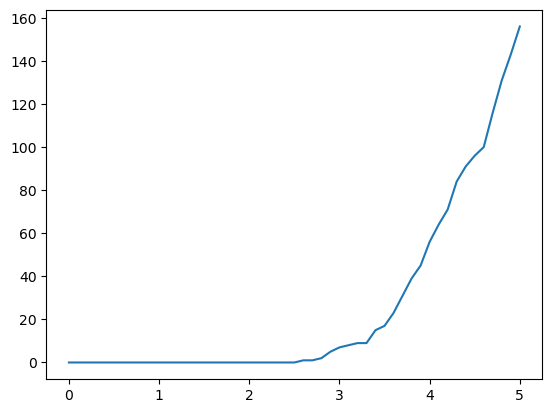

In [14]:
plt.plot(x,y)

In [17]:
d = dm(coor_c,coor_p) < BOND_CUT
a = np.array( np.where(d == 1) )
a = np.array(a)

In [18]:
a

array([], shape=(2, 0), dtype=int64)

In [19]:
import copy

In [20]:
#a = np.array( np.where(d == 1) )
bad_c = []
for ii in range(a.shape[1]):
    bad_c.append( res_c[a[0,ii]] )
    #print(res_c[a[0,ii]], res_p[a[1,ii]])


pre_bad = bad_c;

while True:       
    ccd = dm(coor_c,coor_c) < BOND_CUT
    ccd = np.array( np.where(ccd == 1) )
    ccd =  np.array(ccd)
    print(ccd)
    
    for ii in range(ccd.shape[1]):
        if res_c[ ccd[0,ii] ] in bad_c or res_c[ ccd[1,ii] ] in bad_c:
            if res_c[ccd[0,ii]] not in bad_c:
                bad_c.append( res_c[ccd[0,ii]] )
            if res_c[ccd[1,ii]] not in bad_c:
                bad_c.append( res_c[ccd[1,ii]] )
        #print(res_c[ ccd[0,ii] ], res_c[ccd[1,ii]])
        
    if pre_bad == bad_c:
        break;
    pre_bad = copy.deepcopy(bad_c)
    
bad_c

[[ 0  0  0  0  1  1  1  1  2  2  2  2  3  3  3  3  4  4  4  5  5  5  6  6
   7  7  8  8  8  9  9  9 10 10 11 11 11 11 12 12 12 12 13 13 13 13 14 14
  14 14 15 15 15 16 16 16 16 17 17 18 18 19 19 20 20 20 21 21]
 [ 0  1  5  6  0  1  2  7  1  2  3  8  2  3  4  9  3  4 10  0  5  9  0  6
   1  7  2  8 16  3  5  9  4 10 11 12 16 17 11 12 13 18 12 13 14 19 13 14
  15 20 14 15 21  8 11 16 20 11 17 12 18 13 19 14 16 20 15 21]]


[]

In [21]:
good_c = []
for c in res_c:
    if c in bad_c:
        continue;
    if c not in good_c:
        good_c.append(c)
        
good_c

[['1', 'B', 'BGC'], ['2', 'B', 'BGC']]

In [22]:
#Add non-glycan connections
weirdres = dm(coor_c,coor_x) < BOND_CUT
weirdres = np.array( np.where(weirdres == 1) )
weirdres =  np.array(weirdres)
print(weirdres)

for ii in range(weirdres.shape[1]):
    good_c.append( res_x[weirdres[1,ii]] )



[[ 5]
 [24]]


In [23]:
good_c

[['1', 'B', 'BGC'], ['2', 'B', 'BGC'], ['1309', 'A', 'OXZ']]

In [24]:
class GlycanSelect(Select):
    def accept_residue(self, residue):
        r = residue
        #help(r)
        #if residue.get_resname()=='GLY':
        
        n = str(r.id[1]).strip()
        c = str(r.get_parent().id).strip()
        resname = str(r.get_resname())
        resarr = [n,c,resname]
        #if resname in carb:
        if resarr in good_c:
            return 1
        else:
            return 0
        
io=PDBIO()
io.set_structure(structure)
io.save('good_gly_only.pdb', GlycanSelect())

In [25]:
class ProtSelect(Select):
    def accept_residue(self, residue):
        r = residue
        #help(r)
        #if residue.get_resname()=='GLY':
        
        n = str(r.id[1]).strip()
        c = str(r.get_parent().id).strip()
        resname = str(r.get_resname())
        resarr = [n,c,resname]
        #if resname in carb:
        if resarr in res_p:
            return 1
        else:
            return 0
        
io=PDBIO()
io.set_structure(structure)
io.save('prot_only.pdb', ProtSelect())

In [26]:
#determine chain-chain interactions
d = dm(coor_c,coor_p) < INTERACT
a = np.array( np.where(d == 1) )
a = np.array(a)

#chain_int = {}
chain_int = ''
for ii in range(a.shape[1]):
    if res_c[a[0,ii]] in bad_c:
        continue
    res1 = res_c[ a[0,ii] ]
    res2 = res_p[ a[1,ii] ]
    
    #print(res1,res2)
    
    #chain_int[res1[1]] = res2[1]
    ope = res1[1] + ',' + res2[1]
    if ope not in chain_int:
        chain_int +=ope + '\n'

    #chain_int.update({res1[1]:res2[2]})
    
    #bad_c.append( res_c[a[0,ii]] )
    #print(res_c[a[0,ii]], res_p[a[1,ii]])
    
#chain_int

f = open('chain_int.csv','w+')
f.write(chain_int)
f.close()

In [27]:
print(chain_int)

B,A



In [28]:
os.getcwd()

'/Users/scanner1/Downloads/capdock'

In [29]:
ls[0]

'1HGG.pdb'

In [9]:
pose = pose_from_pdb('./pdbs/' + ls[0])


ERROR: Residue::carbohydrate_info(): This residue is not a carbohydrate!
ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/rosetta/source/src/core/conformation/Residue.cc line: 419


RuntimeError: 

File: /Volumes/scratch/w/rosetta/commits/rosetta/source/src/core/conformation/Residue.cc:419
[ ERROR ] UtilityExitException
ERROR: Residue::carbohydrate_info(): This residue is not a carbohydrate!



In [10]:
pose = pyrosetta.toolbox.pose_from_rcsb('1w3l',ATOM=1)

core.import_pose.import_pose: File '1W3L.clean.pdb' automatically determined to be of type PDB
core.io.util: Found 0 glycan linkages in the structure based on atomic distances
core.io.util: Automatic glycan connection is activated.
core.io.util: Start reordering residues.
core.io.util: Corrected glycan residue order (internal numbering): []
core.io.util:
core.io.util: Found 0 glycan linkages in the structure based on atomic distances


In [11]:
pose

In [9]:
ls[0]

'1HGG.pdb'

In [12]:
r = pose.residue(305)
r.is_carbohydrate()

False

In [3]:
tree_set = pose.glycan_tree_set()

In [6]:
print( tree_set )

None


In [4]:
s = []
for start in tree_set.get_start_points():
    #dont include glycosylated bois
    parent = tree_set.get_parent(start);
    #print(parent)
    if parent != 0:
        continue;
    print(start, pose.pdb_info().pose2pdb(start), pose.residue_type(start).name3(), pose.residue_type(start).name())
    s.append(start)

AttributeError: 'NoneType' object has no attribute 'get_start_points'

In [21]:
tree1 = tree_set.get_tree(s[0])

In [22]:
tree1.get_residues()

vector1_unsigned_long[1525, 1526, 1527]

In [23]:
#single test

out = ""

tree_set = pose.glycan_tree_set()
s = []
for start in tree_set.get_start_points():
    #skip the glycosylated glycans
    parent = tree_set.get_parent(start);
    if parent != 0:
        continue;
    #print(start, pose.pdb_info().pose2pdb(start), pose.residue_type(start).name3(), pose.residue_type(start).name())
    s.append(start)

prot = pose.clone()
    
ind = 0;
for i in s:
    tree = tree_set.get_tree(i)
    
    
    res = np.array(tree.get_residues())
    carb = pose.clone()
    for j in range(pose.size()-1,0,-1):
        if j not in res:
            carb.delete_residue_slow(j)
    #print(carb)
    
    
    #save the carb
    carb.dump_pdb('pdb_pre/1bag_carb' + str(ind) + ".pdb")
    
    #relax the carb and save rosetta relax
    #fr.apply(carb)
    #carb.dump_pdb('pdb_pre/1bag_carb' + str(ind) + "_rosRel.pdb")
    
    ind += 1;
    

#have a clean protein file
for j in range(prot.size(),0,-1):
    #print(j)
    if prot.residue(j).is_protein():
        continue;
    print(j)
    prot.delete_residue_slow(j)
    

#output the fasta
for ii in range(1,prot.num_chains()+1):
    out += ">1BAG_" + str(ii) + "\n"
    out += prot.chain_sequence(ii) + "\n"
    
prot.dump_pdb('pdb_pre/1bag_prot.pdb')
#print(out)
    

RuntimeError: 

File: /Volumes/MacintoshHD3/benchmark/W.fujii.release/rosetta.Fujii.release/_commits_/main/source/build/PyRosetta/macos/clang-9.0.0/python-3.8/release/source/src/core/conformation/Conformation.hh:514
[ ERROR ] UtilityExitException
ERROR: Error in core::conformation::Conformation::residue(): The sequence position requested was greater than the number of residues in the pose.



In [36]:
r = pose.residue(3)

In [37]:
r.natoms()

19

In [38]:
r.name3()

'LEU'

In [45]:
pose.beta(3)

RuntimeError: 

File: /Volumes/MacintoshHD3/benchmark/W.fujii.release/rosetta.Fujii.release/_commits_/main/source/src/core/pose/Pose.cc:1444
[ ERROR ] UtilityExitException
ERROR: Pose::beta( Size const seqpos ): residue seqpos is not part of a Nucleic Acid!



In [50]:
p = pose.pdb_info()
p.bfactor(4,2)

135.18

In [19]:
for i in range(1,20):
    print(r.atom_name(i))

 N  
 CA 
 C  
 O  
 CB 
 CG 
 CD1
 CD2
 H  
 HA 
1HB 
2HB 
 HG 
1HD1
2HD1
3HD1
1HD2
2HD2
3HD2


In [9]:
def dump_res_pdb(pose,res,file):
    
    
    anum = 1;
    resnum = 1;
    out = ''

    for ii in res:
        
        r = pose.residue(ii)
        resnum = r.pose2

        for a in range(1,r.natoms()+1):
            
            aname = r.atom_name(a)
            if 'H' in aname:
                continue;
            if 'V' in aname:
                continue;
            
            out += "ATOM  "
            out += str(anum).rjust(5) + ' '
            out += aname
            out += ' ' # no alt location indicator
            out += r.name3().ljust(4)
            out += 'A'
            out += str(ii).rjust(4)
            out += '   '
            #print(m.coor[a,:])
            coor = r.xyz(a)
            c = str( round(coor[0],3) )
            while len( c.split('.')[1] ) < 3:
                c += '0'
            out += c.rjust(8)
            c = str( round(coor[1],3) )
            while len( c.split('.')[1] ) < 3:
                c += '0'
            out += c.rjust(8)
            c = str( round(coor[2],3) )
            while len( c.split('.')[1] ) < 3:
                c += '0'
            out += c.rjust(8)


            #out += str( round(m.coor[a,1],3) ).rjust(8)
            #out += str( round(m.coor[a,2],3) ).rjust(8)

            out += '\n'
            anum += 1
        resnum += 1

    
    return out
    

In [10]:
def output_pdbs(name,pose):

    out = ""

    #get the number of trees
    tree_set = pose.glycan_tree_set()
    s = []
    for start in tree_set.get_start_points():
        #skip the glycosylated glycans
        parent = tree_set.get_parent(start);
        if parent != 0:
            continue;
        #print(start, pose.pdb_info().pose2pdb(start), pose.residue_type(start).name3(), pose.residue_type(start).name())
        s.append(start)

    #print(pose.size())
    #prot = pose.clone()

    ind = 0;
    for i in s:
        tree = tree_set.get_tree(i)
        res = np.array(tree.get_residues())
        #carb = pose.clone()
        

        print( dump_res_pdb(pose,res,'') )

        #print(carb)


        #save the carb
        #carb.dump_pdb('pdb_pre/' + name + '_carb' + str(ind) + ".pdb")

        #relax the carb and save rosetta relax
        #fr.apply(carb)
        #carb.dump_pdb('pdb_pre/' + name + '_carb' + str(ind) + "_rosRel.pdb")

        #ind += 1;

    #print(pose.size(),carb.size(),prot.size())
    #have a clean protein file
    for j in range(prot.size(),0,-1):
        #print(j)
        if j == 0:
            break;
        if prot.residue(j).is_protein():
            continue;
        #print(j)
        prot.delete_residue_slow(j)

    #print(pose.size(),carb.size(),prot.size())
    #output the fasta
    for ii in range(1,prot.num_chains()+1):
        out += ">" + name + "_" + str(ii) + "\n"
        out += prot.chain_sequence(ii) + "\n"

    prot.dump_pdb('pdb_pre/' + name + '_prot.pdb')
    #print(out)
    return out
    
output_pdbs('1hgg',pose)

NameError: name 'pose' is not defined

In [ ]:
#output_pdbs('1bag',pyrosetta.toolbox.pose_from_rcsb('1bag'.upper(),ATOM=False))
#output_pdbs('1hgg',pose)

In [18]:
fa = ''
for ii in ls[:10]:

    #print(ii[0])
    #try:
        #pdb = ii[0]
        pdb = ii
        print(pdb)
        #pose = pyrosetta.toolbox.pose_from_rcsb(pdb.upper(),ATOM=False)
        pose = pose_from_pdb('./pdbs/' + pdb)
        fa += output_pdbs(pdb,pose)

        f = open('pdbs/fasta.fa','w+')
        f.write(fa)
        f.close()
    #except:
    #    print("Unable: ",pdb)
    
    #break;

1HGG.pdb



ERROR: Residue::carbohydrate_info(): This residue is not a carbohydrate!
ERROR:: Exit from: /Volumes/scratch/w/rosetta/commits/rosetta/source/src/core/conformation/Residue.cc line: 419


RuntimeError: 

File: /Volumes/scratch/w/rosetta/commits/rosetta/source/src/core/conformation/Residue.cc:419
[ ERROR ] UtilityExitException
ERROR: Residue::carbohydrate_info(): This residue is not a carbohydrate!

